## 1.1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx

In [2]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  


SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

In [3]:
def create_k_regular_graph(n, k):
    """
    Create a k-regular graph adjacency matrix where each node is connected
    to its k nearest neighbors in a circular manner.
    """
    rows = []
    cols = []
    
    # For each node i, neighbors are ±1, ±2 ... up to k/2
    half_k = k // 2
    
    for i in range(n):
        for offset in range(1, half_k + 1):
            # right neighbor (i + offset)
            neighbor_r = (i + offset) % n
            rows.append(i)
            cols.append(neighbor_r)
            
            # left neighbor (i - offset)
            neighbor_l = (i - offset) % n
            rows.append(i)
            cols.append(neighbor_l)
            
    data = np.ones(len(rows))
    adj_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(n, n))
    return adj_matrix

In [4]:
def run_simulation(adj_matrix, n_nodes, weeks, beta, rho, initial_infected, initial_infected_choice='random'):
    # at the beginning all nodes are susceptible -> everyone is S = 0
    states = np.zeros(n_nodes, dtype=int)
    
    if initial_infected_choice == 'random':
        initial_infected_indices = np.random.choice(n_nodes, initial_infected, replace=False)
    elif initial_infected_choice == 'cluster':
        start_node = np.random.randint(0, n_nodes)
        initial_infected_indices = [(start_node + i) % n_nodes for i in range(initial_infected)]

    states[initial_infected_indices] = INFECTED
    
    # i = 0 for initial state, i = 1..15 for next weeks
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    new_infections_hist = np.zeros(weeks + 1)
    
    # initial state (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    new_infections_hist[0] = initial_infected
    
    for t in range(weeks):
        # current infected nodes
        infected_mask = (states == INFECTED)
        
        # number of infected neighbors for each node
        m = adj_matrix.dot(infected_mask.astype(int))
        
        # P(S -> I) = 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m
        
        random_vals = np.random.rand(n_nodes)
        
        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)
        
        # P(I -> R) = rho 
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)
        
        # states update synchronously given the discrete time nature of the model
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED
        
        count_S = np.sum(states == SUSCEPTIBLE)
        count_I = np.sum(states == INFECTED)
        count_R = np.sum(states == RECOVERED)
        count_New_I = np.sum(newly_infected_mask)
        
        history_S[t+1] = count_S
        history_I[t+1] = count_I
        history_R[t+1] = count_R
        new_infections_hist[t+1] = count_New_I
        
    return history_S, history_I, history_R, new_infections_hist

### Simulation with random initial infected

Choosing the initial infected randomly the opportunity for the epidemic to expand on the net is maximezed

Given $R_0 = \frac{\beta \cdot k}{\rho} = \frac{1.2}{0.7} > 1$ the epidemic should grow but thanks to the topology of the network the epidemics decrease and can not infect all the population

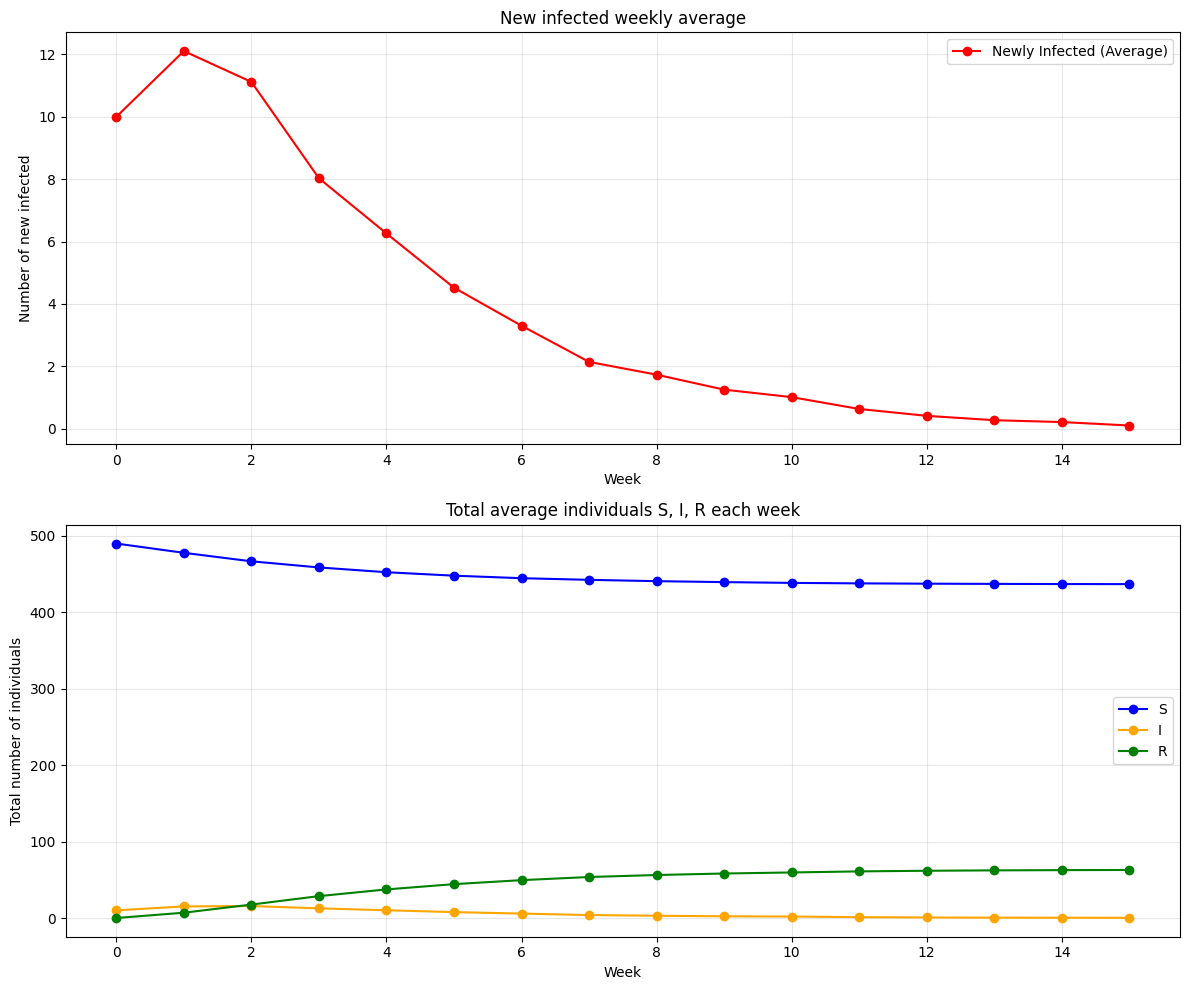

In [5]:
adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED)
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

def plot_epidemic(weeks, avg_S, avg_I, avg_R, avg_new_I):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(weeks, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Average)')
    plt.title('New infected weekly average')
    plt.xlabel('Week')
    plt.ylabel('Number of new infected')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(weeks, avg_S, marker='o', label='S', color='blue')
    plt.plot(weeks, avg_I, marker='o', label='I', color='orange')
    plt.plot(weeks, avg_R, marker='o', label='R', color='green')
    plt.title('Total average individuals S, I, R each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

even trying different values of $\beta$ and $\rho$

- with $\beta \cdot k < \rho$: no peak
- with $\beta \cdot k \ge \rho$: peak but then the topology of the net still avoids the epidemic infecting all the population

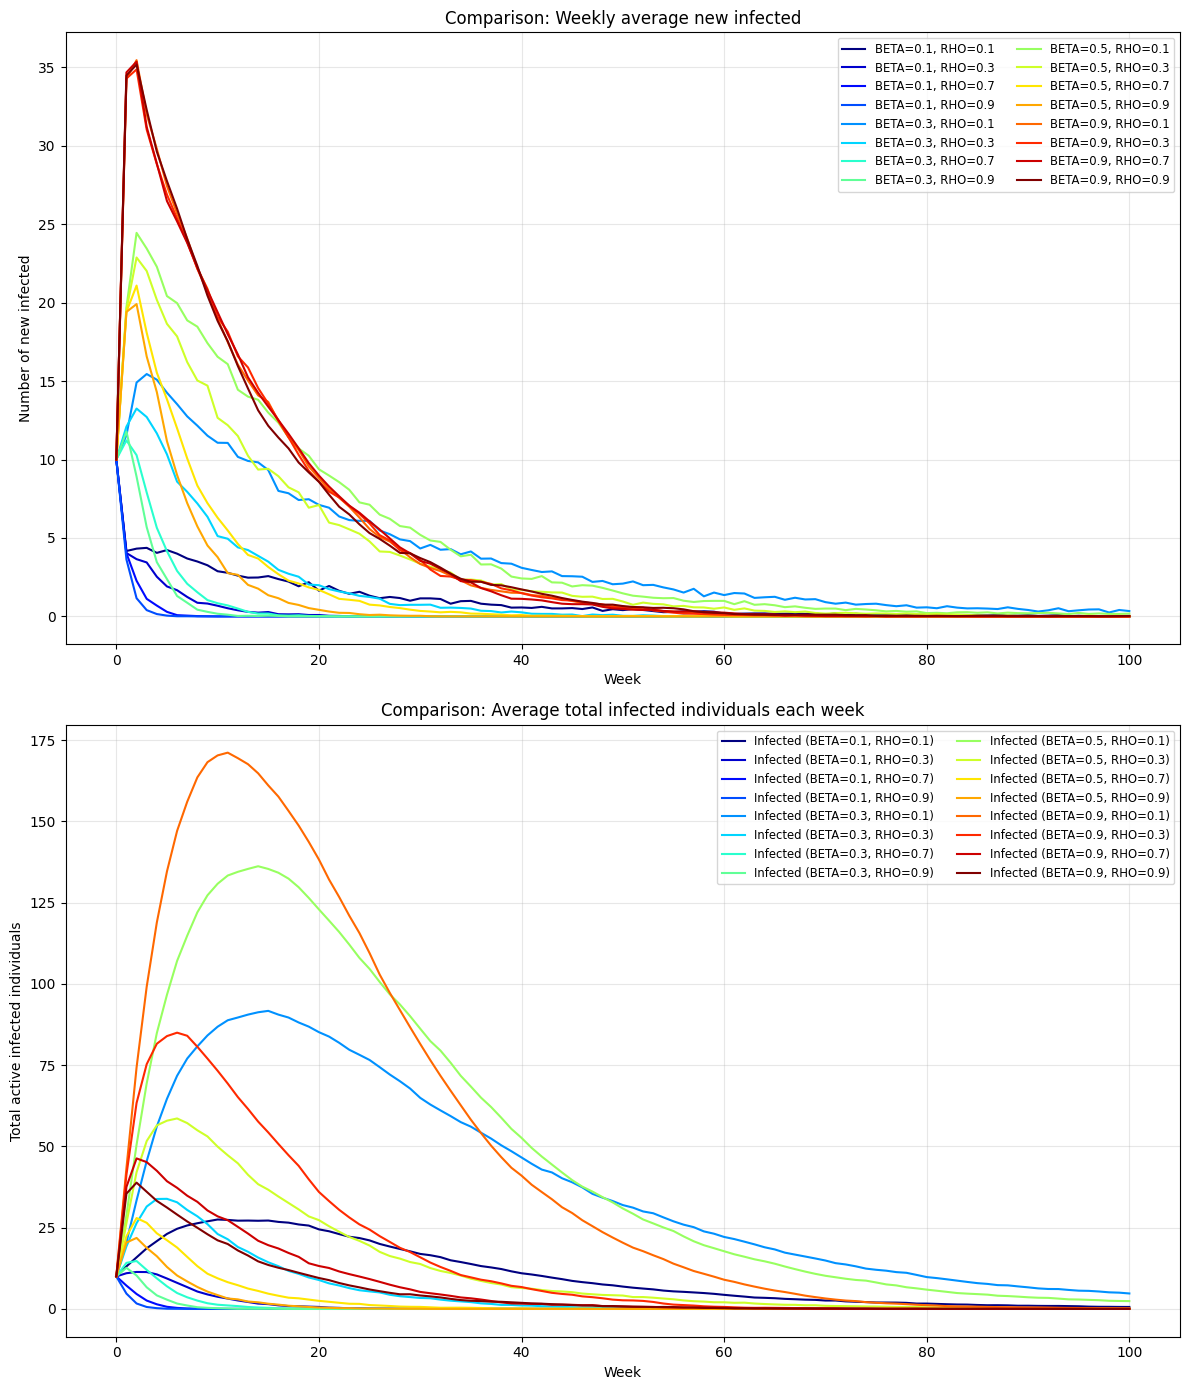

In [6]:
BETA = [0.1, 0.3, 0.5, 0.9]
RHO = [0.1, 0.3, 0.7, 0.9]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(BETA) * len(RHO))) 
c_idx = 0

for beta in BETA:
    for rho in RHO:
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, beta, rho, INITIAL_INFECTED)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'BETA={beta}, RHO={rho}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

### Simulation with initial infected taken from a cluster

Choosing 10 neighbor nodes as initial infected, the epidemic dies out even faster because the initial infected shares the same suscepitble neighbors saturating the infection locally.

In a cluster, many of the links of infected nodes point to other already infected nodes within the group. These links are "wasted" because they cannot transmit the infection to new susceptible nodes. In the random configuration, however, almost all the links of the 10 infected nodes point to susceptible nodes, maximizing the probability of immediate expansion.

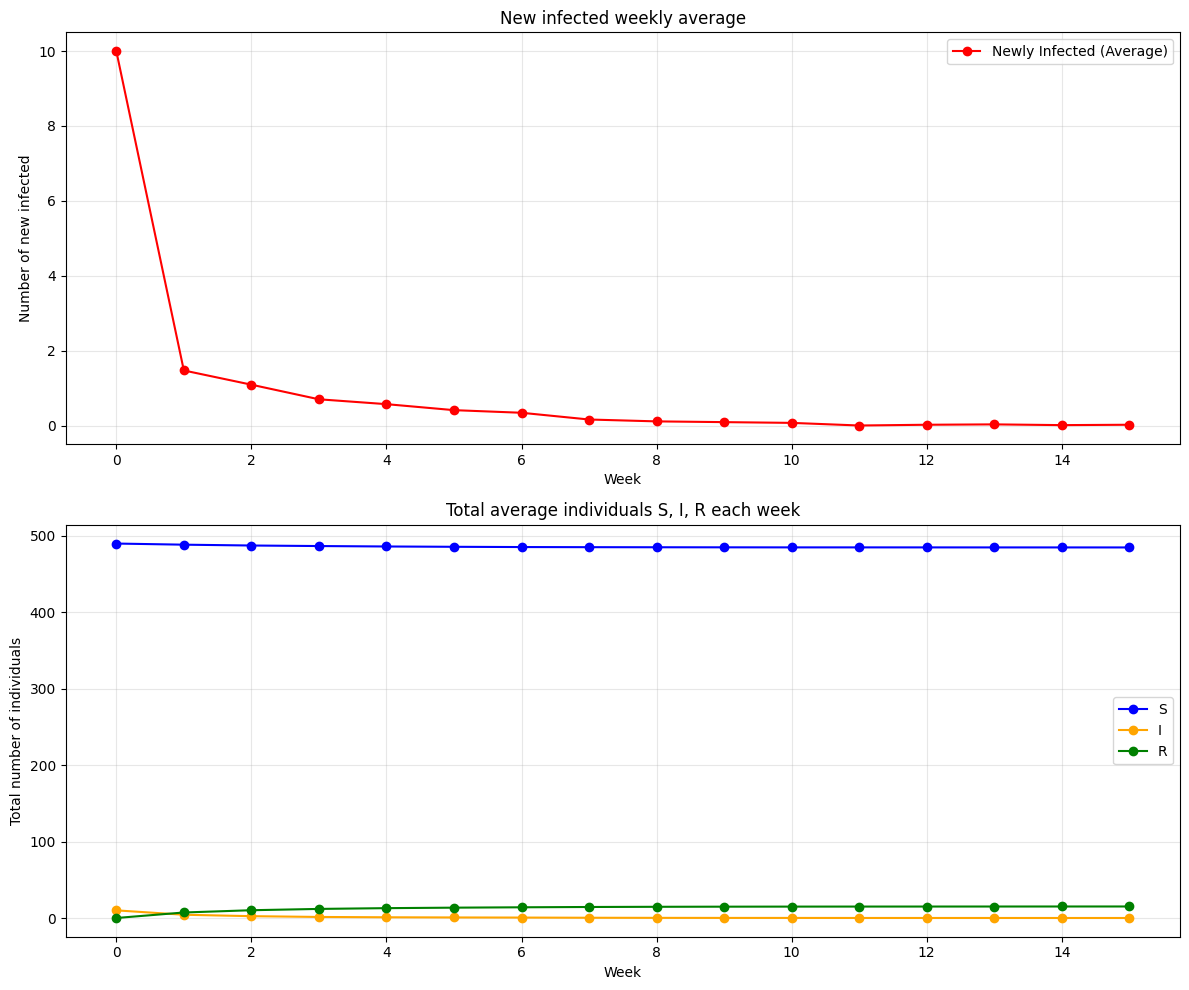

In [7]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  

adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED, initial_infected_choice='cluster')
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)
plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

### Simulation with different values of $k$ and initial infected

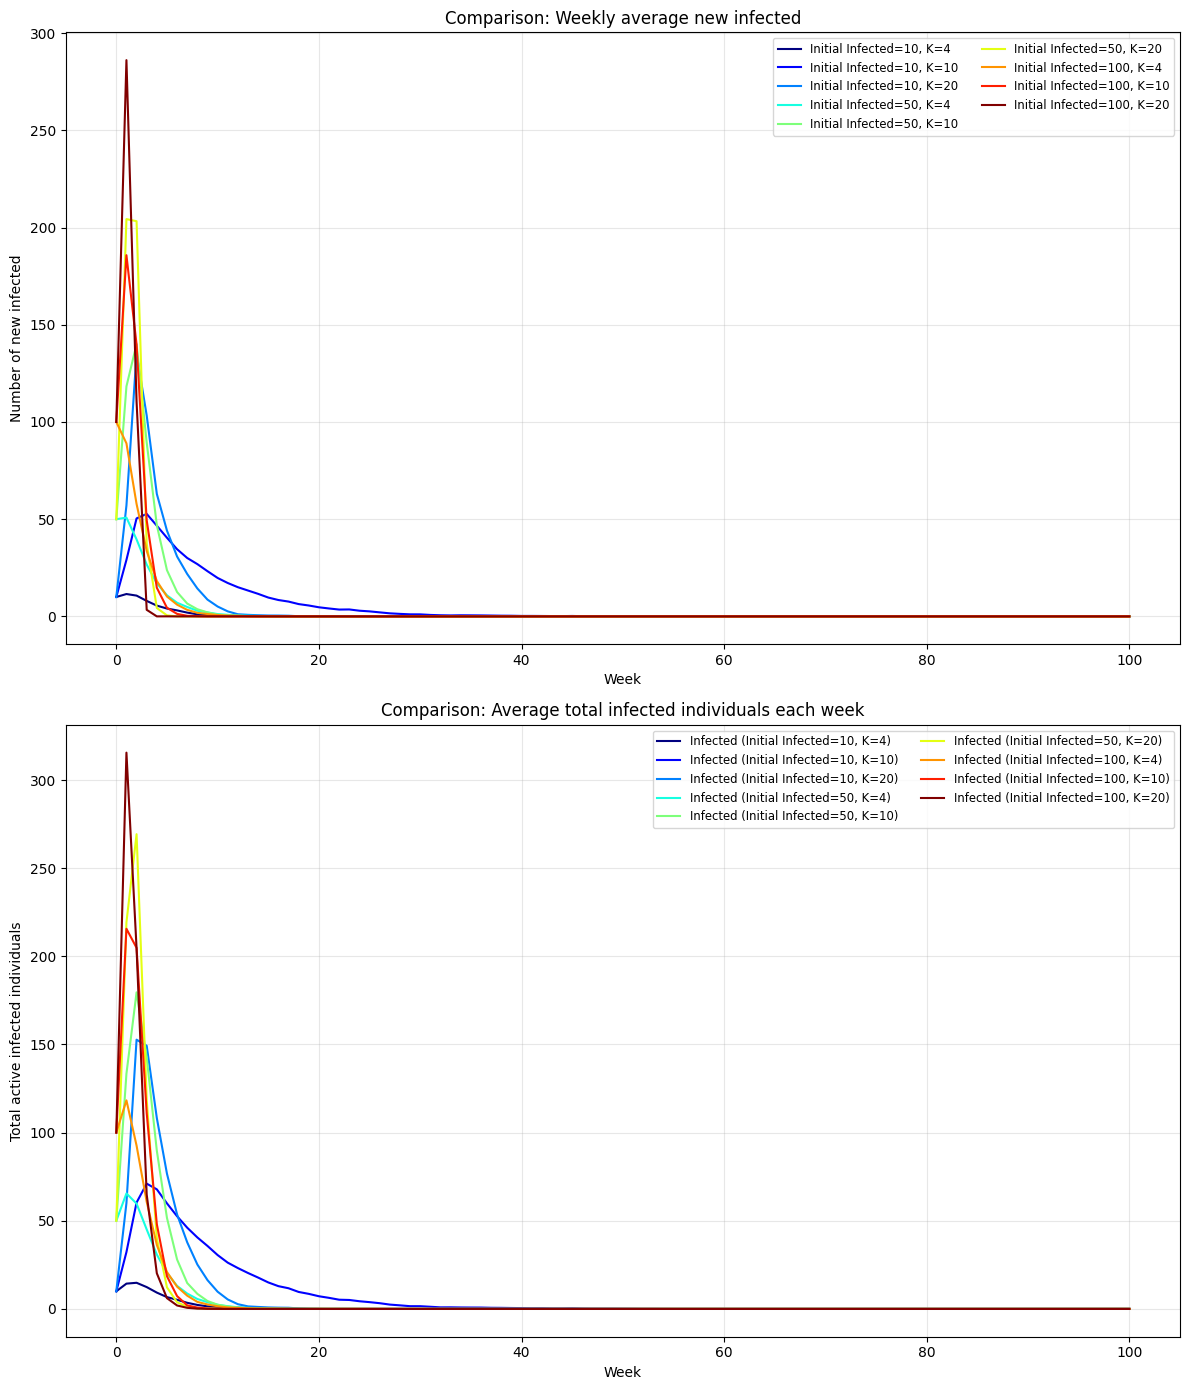

In [8]:
BETA = 0.3
RHO = 0.7
INITIAL_INFECTED = [10, 50, 100]
K_NEIGHBORS = [4, 10, 20]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(INITIAL_INFECTED) * len(K_NEIGHBORS))) 
c_idx = 0

for initial_infected in INITIAL_INFECTED:
    for k in K_NEIGHBORS:
        adj_matrix = create_k_regular_graph(N_NODES, k)
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, initial_infected)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'Initial Infected={initial_infected}, K={k}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

## 1.1.2

In [9]:
def generate_PA_graph_target_k(n_total, k):
    """
    Generates a Preferential Attachment graph with n_total nodes 
    and a target average degree of k.
    """
    
    # INITIALIZATION (Time t=1)
    # Start with a complete graph (clique) of k+1 nodes
    # This ensures the initial average degree is exactly k.
    m0 = k + 1
    G = nx.complete_graph(m0)
    
    # Parameters for the alternating mechanism
    is_k_odd = (k % 2 != 0)
    c_floor = int(np.floor(k / 2))
    c_ceil = int(np.ceil(k / 2))
    
    # GROWTH (Time t >= 2)
    # We add nodes one by one from index m0 up to n_total - 1
    for new_node in range(m0, n_total):
        
        # Determine c (number of edges to add)
        if is_k_odd:
            # Alternate between floor and ceil
            # We use the node index to decide (even or odd step)
            if new_node % 2 == 0:
                c = c_floor
            else:
                c = c_ceil
        else:
            # If k is even, c is always k/2
            c = int(k / 2)
            
        # Get the list of existing nodes
        existing_nodes = np.array(G.nodes())
        
        # Get degrees of all existing nodes (w_i(t-1))
        # Note: G.degree() returns (node, degree) tuples, we just need the degrees
        degrees = np.array([G.degree(n) for n in existing_nodes])
        
        # Calculate the sum of degrees (Denominator of the formula)
        degree_sum = degrees.sum()
        
        # Calculate Probabilities
        # P(i) = w_i / sum(w)
        probabilities = degrees / degree_sum
        
        # Select 'c' targets based on these probabilities
        # replace=False ensures we do not add multiple links to the same node
        targets = np.random.choice(existing_nodes, size=c, replace=False, p=probabilities)
        
        # Add the new node and the edges
        G.add_node(new_node)
        for target in targets:
            G.add_edge(new_node, target)
            
    return G

Target Average Degree: 8
Actual Average Degree: 8.0000


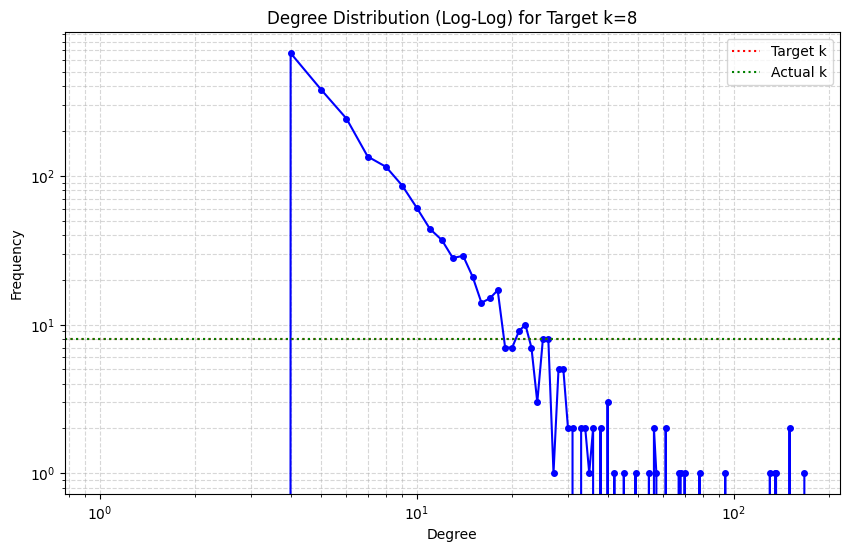

In [10]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 8 # Target average degree (even number for default case)

# Generate Graph
G_pa = generate_PA_graph_target_k(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_freq = nx.degree_histogram(G_pa)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq, 'bo-', markersize=4)
plt.axhline(y=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axhline(y=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Log-Log) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

Target Average Degree: 5
Actual Average Degree: 5.0000


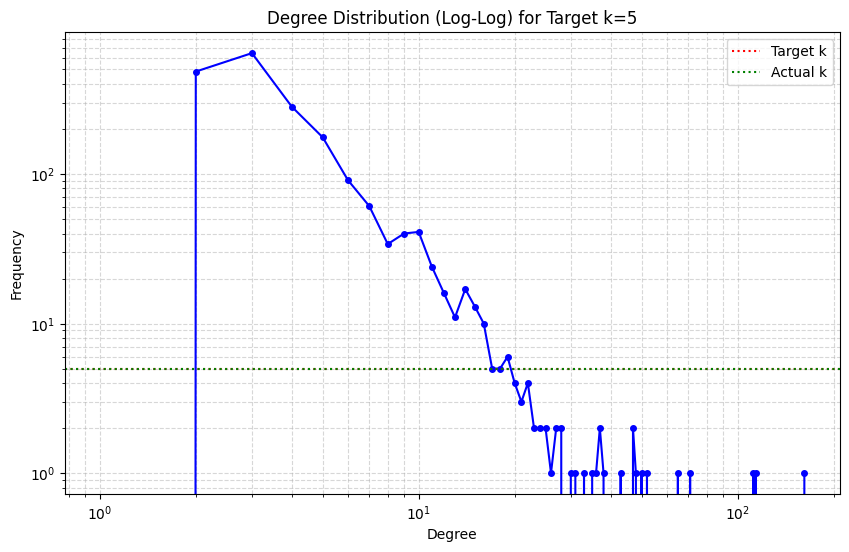

In [11]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 5 # Target average degree (Odd number to test the tricky case)

# Generate Graph
G_pa = generate_PA_graph_target_k(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_freq = nx.degree_histogram(G_pa)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq, 'bo-', markersize=4)
plt.axhline(y=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axhline(y=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Log-Log) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()